<a href="https://colab.research.google.com/github/nguyenthanhtuhcm/luanvan/blob/main/face_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

encode_faces

In [11]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 21 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=bc03cbc317a20881bd3a9e50fbee607f2a9a20df243f40e539fd5412cacd0362
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [12]:
cd /content/drive/MyDrive/Cao Học/ThiGiacUngDung/Face_Clustering

/content/drive/MyDrive/Cao Học/ThiGiacUngDung/Face_Clustering


In [57]:
%%writefile encode_faces.py
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os

# construct argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--dataset", required=True,	help="đường dẫn đến thư mục input chứa các images khuôn mặt")
ap.add_argument("-e", "--encodings", required=True,	help="đường dẫn đến serialized db, chứa các facial encodings")
ap.add_argument("-d","--detection-method", type=str, default="cnn",	help="mô hình face detection được sử dụng: 'hog' hoặc 'cnn'")
args = vars(ap.parse_args())
# paths to input images in our dataset 
print("[INFO] quantifying faces....")
imagePaths = list(paths.list_images(args["dataset"]))
data = []

# loop over image paths
for (i, imagePath) in enumerate(imagePaths):
	# load input image and convert it from RGB (OpenCV ordering)
	# to dlib ordering (RGB)
	print("[INFO] processing image {}/{}".format(i+1, len(imagePaths)))
	print(imagePath)
	image = cv2.imread(imagePath)
	rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	
	# detect the (x,y) coordinates of the bounding boxes
	# corresponding to each face in the input image
	boxes = face_recognition.face_locations(rgb, model=args["detection_method"])

	# compute the facial embedding for the face
	encodings = face_recognition.face_encodings(rgb, boxes)

	# build a dictionary of the image path, bounding box location,
	# and facial encodings for the current image
	d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
		for (box,enc) in zip(boxes, encodings)]
	data.extend(d)

#dump the facial encodings to disk
print("[INFO] serializing encodings...")
f = open(args["encodings"],"wb")
f.write(pickle.dumps(data))
f.close()


Overwriting encode_faces.py


In [ ]:
!python3 encode_faces.py --dataset "dataset" --encodings "encodings.pickle"

In [13]:
%%writefile config.py
configurations = {
    1: dict(
        encodings = '/content/drive/MyDrive/Cao Học/ThiGiacUngDung/Face_Clustering/encodings.pickle', # đường dẫn đến serialized db của các facial encodings
        jobs = 1, # of parallel jobs to run (-1 will use all CPUs)
),
}

Overwriting config.py


Cluster_faces

[INFO] loading encodings...
[INFO] clustering...
[INFO] # unique faces : 5
[INFO] faces for face ID: -1


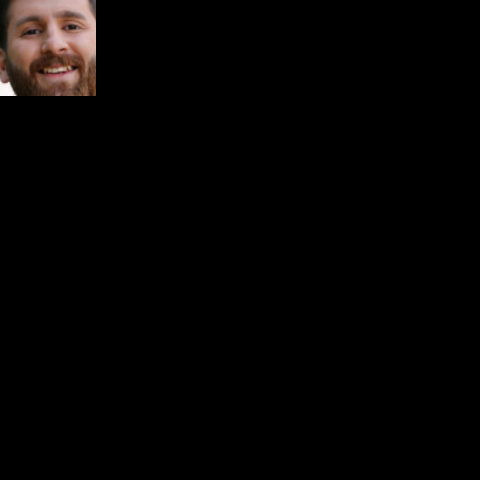

[INFO] faces for face ID: 0


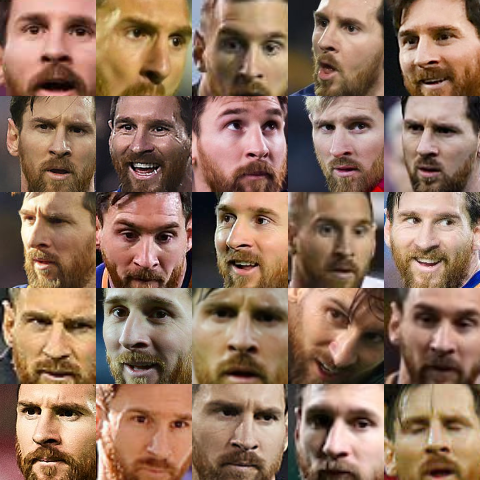

[INFO] faces for face ID: 1


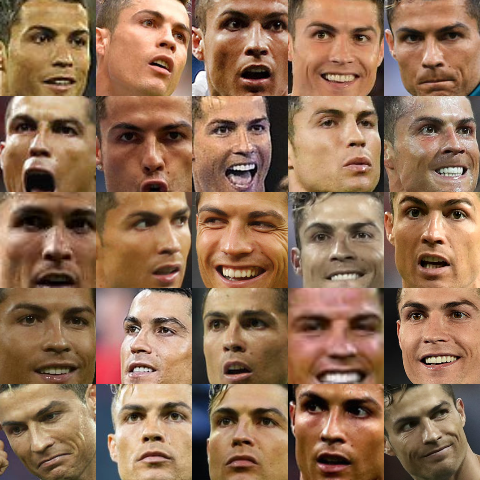

[INFO] faces for face ID: 2


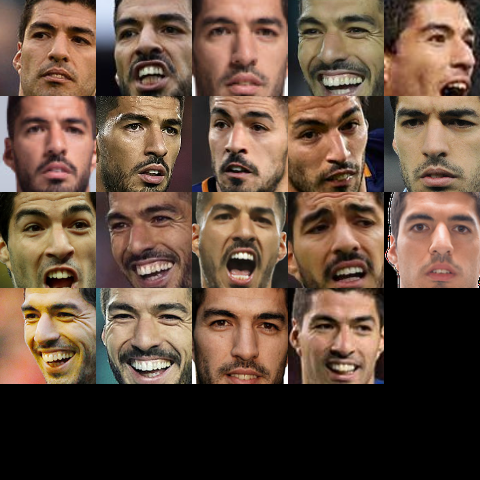

[INFO] faces for face ID: 3


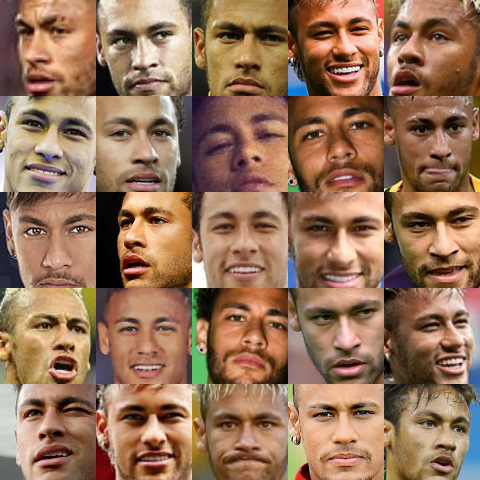

[INFO] faces for face ID: 4


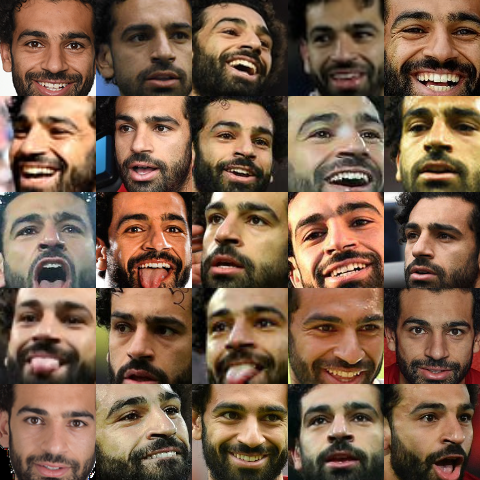

In [22]:
#%%writefile cluster_faces.py
from config import configurations
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import pickle
import cv2
from google.colab.patches import cv2_imshow

# load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings so we can cluster them
cfg = configurations[1]
print("[INFO] loading encodings...")
data = pickle.loads(open(cfg["encodings"],"rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
# cluster the embeddings
print("[INFO] clustering...")
clt = DBSCAN(metric="euclidean", n_jobs=cfg["jobs"])
clt.fit(encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
#print(labelIDs)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces : {}".format(numUniqueFaces))

# loop over the unique face integers
for labelID in labelIDs:
    # find all the indexes into the 'data' array that belong to the
    # current label ID, then randomly sample a maximum of 25 index from the set
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    #print(idxs)
    idxs = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)
    # initialize the list of faces to include in the montage
    faces = []
    # loop over the sampled indexes
    for i in idxs:
        # load the input image and extract the face ROI
        image = cv2.imread(data[i]["imagePath"])   
        #print(image)  
        (top, right, bottom, left) = data[i]["loc"]
        face = image[top:bottom, left:right]       
        # force resize the face ROI to 96x96 and then add it to the
        # faces montage list
        face = cv2.resize(face, (96,96))
        faces.append(face)
    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96,96), (5,5))[0]
    # show the output montage
    title = "Face ID #{}".format(labelID)
    title = "Unknown Faces" if labelID == -1 else title
    cv2_imshow(montage)
    cv2.waitKey(0)

In [ ]:
!python3 cluster_faces.py